In [1]:
import os
import sys
import pandas as pd
import numpy as np
from sklearn import preprocessing
import tensorflow as tf
import random
import matplotlib
from matplotlib import pyplot as plt
import statistics
from pandas import DataFrame
from datetime import datetime
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
#from keras import backend as K
#import keras.backend.tensorflow_backend as K
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from os.path import basename
#import seaborn as sns
# from keras.models import load_model
# from keras.utils.vis_utils import plot_model
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from scipy.stats import pearsonr

# from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
#from tensorflow.keras.optimizers import Adam




# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.7
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())


# 출처: https://3months.tistory.com/206 [Deep Play]

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12461791491889205959
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 12011004499876398624
physical_device_desc: "device: 0, name: TITAN RTX, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:GPU:1"
device_type: "GPU"
memory_limit: 22904492544
locality {
  bus_id: 1
  links {
  }
}
incarnation: 9574699866382603051
physical_device_desc: "device: 1, name: TITAN RTX, pci bus id: 0000:03:00.0, compute capability: 7.5"
]


In [3]:
workdir = "D://ResNetIC50//Dataset//MEYDG-51K"

In [4]:
# < Important note > [ Please download input data from https://mega.nz/#F!CeYGDKyS!uqkmWJ4E2XSGJp_C2VO2gg]

dataset = np.load(workdir + "//MEYDG51K_dataset.npz") # input file
ss0 = np.load(workdir + '//MEYDG51K_dataset_r2.npz') # split for training and test

In [5]:
x = dataset['x']
y = dataset['y']
# y_linear = dataset['y_lnIC50']
ss0_train = ss0['train']
ss0_test = ss0['test']

In [6]:
training_image_array, training_label_array = x[ss0_train], y[ss0_train]
test_image_array, test_label_array = x[ss0_test], y[ss0_test]

# # In[9]:
# ori = training_image_array
# bat = np.zeros((ori.shape[0],178))
# cat = np.hstack([ori,bat])
# training_image_array = cat

# # In[8]:
# training_image_array.shape

# # In[10]:
# ori2 = test_image_array
# bat2 = np.zeros((ori2.shape[0],178))
# cat2 = np.hstack([ori2,bat2])
# test_image_array = cat2


In [7]:
# In[15]:
ab =[]
for i in range(100,300):
    ab.append(len(training_image_array) % i)
    
print(min(ab), ab.index(min(ab)))

2 94


In [8]:
x.shape

(51951, 62718)

In [9]:
training_image_array.shape

(46756, 62718)

In [10]:
# In[21]:

num_classes = 1
learning_rate = 0.0002
training_epochs = 150
batch_size = 100
# img_rows, img_cols = 154, 154


In [11]:
train_X, train_y, test_X, test_y = training_image_array, training_label_array, test_image_array, test_label_array

# if K.image_data_format() == 'channels_first':
#     train_X = train_X.reshape(train_X.shape[0], 1, img_rows, img_cols)
#     test_X = test_X.reshape(x_test.shape[0], 1, img_rows, img_cols)
#     input_shape = (1, img_rows, img_cols)
# else:
#     train_X = train_X.reshape(train_X.shape[0], img_rows, img_cols, 1)
#     test_X = test_X.reshape(test_X.shape[0], img_rows, img_cols, 1)
#     input_shape = (img_rows, img_cols, 1)


In [12]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1],1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1],1)
#input_shape = (img_rows, img_cols, 1)

In [13]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(46756, 62718, 1) (46756,) (5195, 62718, 1) (5195,)


In [14]:
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')
# train_X /= 255
# test_X /= 255
print('train_X shape:', train_X.shape)
print(train_X.shape[0], 'train samples')
print(test_X.shape[0], 'test samples')

train_X shape: (46756, 62718, 1)
46756 train samples
5195 test samples


In [15]:
training_image_array.shape

(46756, 62718)

In [16]:
# In[10]:
with tf.device('/GPU:0'):
    inputs = Input(shape=(train_X.shape[1],1),name='inputs')

    x = Conv1D(16, kernel_size=3, strides=2, padding="same")(inputs)
    x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
#     y = x
    x = Activation('tanh')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)
    
    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    
    x = Conv1D(16, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Conv1D(32, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(32, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=2, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
#     x = BatchNormalization()(x)
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
        
    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    y = x
    x = Activation('relu')(x)

    x = Conv1D(64, kernel_size=3, strides=1, padding="same")(x)
#     x = MaxPooling1D(pool_size=5)(x)
    x = BatchNormalization()(x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)

#     x = AveragePooling1D(pool_size=8)(x)
    x = Flatten()(x)
    x = Dense(units=2048, name='dense1'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout1') (x)
    x = Activation('relu')(x)

#    x = Reshape((300,1))(x)

#    x = Conv1D(30, kernel_size=150, strides=1, activation = 'relu')(x)
#    x = MaxPooling1D(pool_size=2)(x)
#    x = BatchNormalization()(x)

    x = Dense(units=1024, name='dense5'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout5') (x)
    x = Activation('relu')(x)

    x = Dense(units=512, name='dense6'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout6') (x)
    x = Activation('relu')(x)

    x = Dense(units=1024, name='dense7'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout7') (x)
    x = tf.keras.layers.add([x,y])
    x = Activation('relu')(x)
    
    x = Dense(units=512, name='dense8'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout8') (x)
    x = Activation('relu')(x)
    
    x = Dense(units=256, name='dense9'  ) (x)
    x = BatchNormalization()(x)
    x = Dropout(0.1, name='dropout9') (x)
    x = Activation('relu')(x)

    x = Dense(units=128, name='dense10'  ) (x)
    x = BatchNormalization()(x)
    y = x
    x = Dropout(0.1, name='dropout10') (x)
    x = Activation('relu')(x)


    predictions = Dense(1, activation='linear', name='predictions', kernel_initializer='he_normal')(x)
#     predictions = Dense(1, activation='linear', name='predictions')(x)

    

    model = Model(inputs=inputs, outputs=predictions, name='Test_v2_DNN20190327')
    model.compile(loss=tf.keras.losses.mean_squared_error,
                  optimizer=tf.keras.optimizers.Adam(learning_rate),
                  metrics=['mse','mae'])


    model.summary()


Model: "Test_v2_DNN20190327"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, 62718, 1)]   0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 31359, 16)    64          inputs[0][0]                     
__________________________________________________________________________________________________
max_pooling1d (MaxPooling1D)    (None, 6271, 16)     0           conv1d[0][0]                     
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 6271, 16)     64          max_pooling1d[0][0]              
________________________________________________________________________________

In [17]:
StartTime8 = datetime.now()
print("StartTime :", StartTime8)
with tf.device('/GPU:0'):
    model_train = model.fit(train_X, training_label_array, batch_size=batch_size,epochs=training_epochs,verbose=1,
                        validation_data=(test_X, test_label_array))

EndTime8 = datetime.now()
print("EndTime :", EndTime8)

StartTime : 2022-02-09 13:17:32.884741
Epoch 1/150
468/468 [==============================] - 99s 199ms/step - loss: 6.3909 - mse: 6.3909 - mae: 1.9613 - val_loss: 14.5132 - val_mse: 14.5132 - val_mae: 3.0243
Epoch 2/150
468/468 [==============================] - 93s 198ms/step - loss: 1.9021 - mse: 1.9021 - mae: 1.0501 - val_loss: 1.7826 - val_mse: 1.7826 - val_mae: 0.9920
Epoch 3/150
468/468 [==============================] - 94s 201ms/step - loss: 1.6907 - mse: 1.6907 - mae: 0.9887 - val_loss: 1.5820 - val_mse: 1.5820 - val_mae: 0.9440
Epoch 4/150
468/468 [==============================] - 95s 202ms/step - loss: 1.4464 - mse: 1.4464 - mae: 0.9138 - val_loss: 1.3739 - val_mse: 1.3739 - val_mae: 0.8743
Epoch 5/150
468/468 [==============================] - 95s 203ms/step - loss: 1.3369 - mse: 1.3369 - mae: 0.8807 - val_loss: 1.3696 - val_mse: 1.3696 - val_mae: 0.8682
Epoch 6/150
468/468 [==============================] - 94s 201ms/step - loss: 1.2062 - mse: 1.2062 - mae: 0.8403 - val_

468/468 [==============================] - 95s 203ms/step - loss: 0.2132 - mse: 0.2132 - mae: 0.3553 - val_loss: 1.0098 - val_mse: 1.0098 - val_mae: 0.7232
Epoch 50/150
468/468 [==============================] - 95s 203ms/step - loss: 0.2067 - mse: 0.2067 - mae: 0.3500 - val_loss: 1.0030 - val_mse: 1.0030 - val_mae: 0.7236
Epoch 51/150
468/468 [==============================] - 95s 203ms/step - loss: 0.1985 - mse: 0.1985 - mae: 0.3442 - val_loss: 1.0042 - val_mse: 1.0042 - val_mae: 0.7154
Epoch 52/150
468/468 [==============================] - 94s 202ms/step - loss: 0.1907 - mse: 0.1907 - mae: 0.3376 - val_loss: 0.9997 - val_mse: 0.9997 - val_mae: 0.7226
Epoch 53/150
468/468 [==============================] - 94s 201ms/step - loss: 0.1971 - mse: 0.1971 - mae: 0.3426 - val_loss: 0.9994 - val_mse: 0.9994 - val_mae: 0.7214
Epoch 54/150
468/468 [==============================] - 94s 201ms/step - loss: 0.1940 - mse: 0.1940 - mae: 0.3382 - val_loss: 1.0084 - val_mse: 1.0084 - val_mae: 0.7290

468/468 [==============================] - 95s 203ms/step - loss: 0.1093 - mse: 0.1093 - mae: 0.2547 - val_loss: 0.9699 - val_mse: 0.9699 - val_mae: 0.7044
Epoch 98/150
468/468 [==============================] - 95s 203ms/step - loss: 0.1112 - mse: 0.1112 - mae: 0.2548 - val_loss: 0.9601 - val_mse: 0.9601 - val_mae: 0.7018
Epoch 99/150
468/468 [==============================] - 95s 203ms/step - loss: 0.1102 - mse: 0.1102 - mae: 0.2558 - val_loss: 0.9597 - val_mse: 0.9597 - val_mae: 0.7021
Epoch 100/150
468/468 [==============================] - 94s 201ms/step - loss: 0.1146 - mse: 0.1146 - mae: 0.2579 - val_loss: 0.9683 - val_mse: 0.9683 - val_mae: 0.6971
Epoch 101/150
468/468 [==============================] - 94s 201ms/step - loss: 0.1060 - mse: 0.1060 - mae: 0.2506 - val_loss: 0.9609 - val_mse: 0.9609 - val_mae: 0.7010
Epoch 102/150
468/468 [==============================] - 94s 202ms/step - loss: 0.1075 - mse: 0.1075 - mae: 0.2524 - val_loss: 0.9495 - val_mse: 0.9495 - val_mae: 0.6

468/468 [==============================] - 94s 201ms/step - loss: 0.0755 - mse: 0.0755 - mae: 0.2095 - val_loss: 0.9479 - val_mse: 0.9479 - val_mae: 0.6880
Epoch 146/150
468/468 [==============================] - 94s 201ms/step - loss: 0.0761 - mse: 0.0761 - mae: 0.2111 - val_loss: 0.9555 - val_mse: 0.9555 - val_mae: 0.6922
Epoch 147/150
468/468 [==============================] - 94s 201ms/step - loss: 0.0795 - mse: 0.0795 - mae: 0.2159 - val_loss: 0.9535 - val_mse: 0.9535 - val_mae: 0.6867
Epoch 148/150
468/468 [==============================] - 94s 201ms/step - loss: 0.0782 - mse: 0.0782 - mae: 0.2140 - val_loss: 0.9831 - val_mse: 0.9831 - val_mae: 0.7117
Epoch 149/150
468/468 [==============================] - 94s 201ms/step - loss: 0.0901 - mse: 0.0901 - mae: 0.2277 - val_loss: 0.9569 - val_mse: 0.9569 - val_mae: 0.6919
Epoch 150/150
468/468 [==============================] - 94s 201ms/step - loss: 0.0788 - mse: 0.0788 - mae: 0.2145 - val_loss: 0.9847 - val_mse: 0.9847 - val_mae: 0

In [18]:
import json
workdir = "D://ResNetIC50//Result//MEYDG-51K//ResNet"
# Option 1: Save Weights + Architecture
model.save_weights(workdir+ '//MEYDG51K_r2_ResNet_model_fix_v3.h5')
with open(workdir + '//MEYDG51K_r2_ResNet_model_architecture_fix_v3.json', 'w') as f:
    f.write(model.to_json())
# Option 1: Load Weights + Architecture
# with open('model_architecture.json', 'r') as f:
#     new_model_1 = model_from_json(f.read())
# new_model_1.load_weights('model_weights.h5')

In [19]:
# Option 2: Save/Load the Entire Model
# Creates a HDF5 file 'my_model.h5'
model.save(workdir + '//MEYDG51K_r2_ResNet_model_fix_2080ti_v3.h5')

# Deletes the existing model
# del model  

# Returns a compiled model identical to the previous one
# model = load_model('my_model.h5')

In [20]:
test_eval = model.evaluate(test_X, test_label_array, verbose=1)

163/163 [==============================] - 4s 24ms/step - loss: 0.9847 - mse: 0.9847 - mae: 0.7048


In [21]:
test_eval

[0.9847220182418823, 0.9847220182418823, 0.7048006057739258]

In [22]:
accuracy = model_train.history['mse']
val_accuracy = model_train.history['val_mse']
loss = model_train.history['loss']
val_loss = model_train.history['val_loss']

np_acc = np.array(accuracy)
np_val_acc = np.array(val_accuracy)
np_loss = np.array(loss)
np_val_loss = np.array(val_loss)

In [23]:
import matplotlib
from matplotlib import pyplot as plt

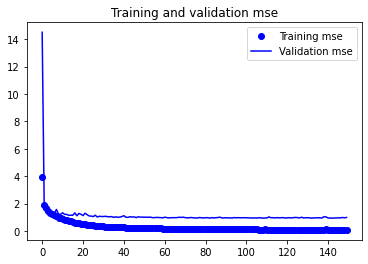

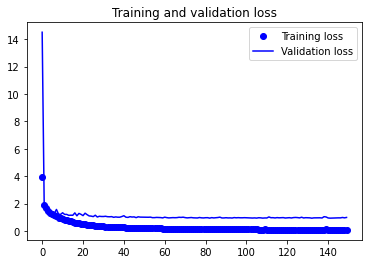

In [24]:
# accuracy = model_train.history['acc']
# val_accuracy = model_train.history['val_acc']
# loss = model_train.history['loss']
# val_loss = model_train.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training mse')
plt.plot(epochs, val_accuracy, 'b', label='Validation mse')
plt.title('Training and validation mse')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [25]:
predicted_classes = model.predict(test_X)

In [26]:
predicted_value = predicted_classes

In [27]:
a = pd.DataFrame(predicted_value)
b = pd.DataFrame(test_label_array)
c = pd.concat([a,b], axis=1)
c.columns=["Predicted","Test"]

In [28]:
c.to_csv(workdir + '//MEYDG51K_r2_ResNet_pred_obs_table.csv')

In [29]:
c

,Predicted,Test
0,-1.125813,2.238455
1,-5.869782,-5.247020
2,2.762841,3.697080
3,-0.623295,-2.907118
4,3.582215,2.840567
...,...,...
5190,1.627072,1.671591
5191,-2.243700,-1.002100
5192,2.475152,2.013122
5193,2.381003,2.355219


In [30]:
predicted_value.shape

(5195, 1)

In [31]:
from scipy.stats import linregress
linregress(b[0], a[0])

LinregressResult(slope=0.8772933450017351, intercept=0.28909021624213316, rvalue=0.93464261065513, pvalue=0.0, stderr=0.0046316722446752825, intercept_stderr=0.015648518341070086)

In [32]:
from sklearn.metrics import r2_score
r2_value = r2_score(b,a)
print(r2_value)

0.8731566952130893


In [33]:
rse = ((b[0]-a[0])**2).sum()
mse = rse / len(b)
print("Final rmse value is =",np.sqrt(mse))

Final rmse value is = 0.992331604532571


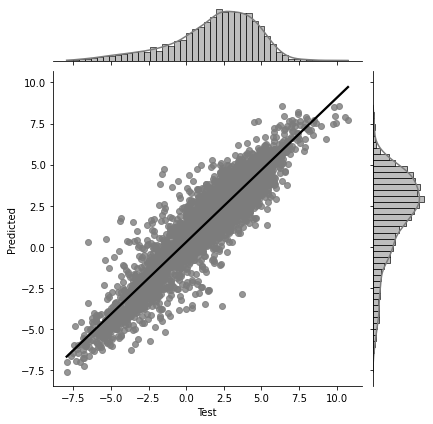

In [34]:
workdir = "D://ResNetIC50//Result//Figure//MEYDG-51K"
import seaborn as sns

g = sns.jointplot(x="Test", y="Predicted", data=c, kind='reg', color='#7C7C7C',
                  joint_kws={'line_kws':{'color':'black'}})
g.savefig(workdir+ '//MEYDG51K_r2_ResNet.png', dpi=300)